<a href="https://colab.research.google.com/github/arooshahz/imdb-sentiment-analysis/blob/main/IMDb_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset

from collections import Counter
import re

sns.set(style="whitegrid")


In [ ]:
dataset = load_dataset("imdb")
dataset

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

The IMDB dataset consists of 50,000 movie reviews, split evenly into training and test sets. Each sample contains a review text and a binary sentiment label.

In [ ]:
train_df = pd.DataFrame(dataset["train"])
test_df = pd.DataFrame(dataset["test"])

train_df.head()

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    25000 non-null  object
 1   label   25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


In [ ]:
train_df.isnull().sum()

,0
text,0
label,0


No missing values are present in either the text or label columns, indicating a clean dataset suitable for downstream modeling.

In [ ]:
label_counts = train_df["label"].value_counts()

label_counts

,count
label,
0,12500
1,12500


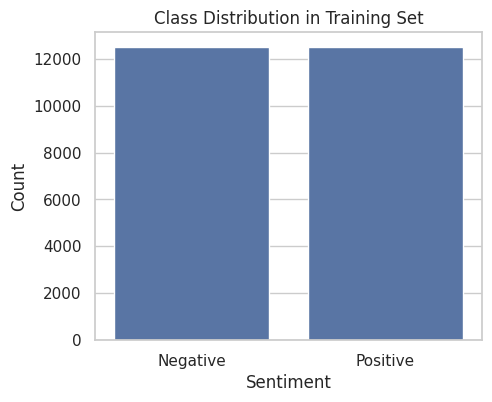

In [ ]:
plt.figure(figsize=(5,4))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xticks([0,1], ["Negative", "Positive"])
plt.title("Class Distribution in Training Set")
plt.ylabel("Count")
plt.xlabel("Sentiment")
plt.show()

The dataset is perfectly balanced, with an equal number of positive and negative reviews. This allows us to rely on accuracy and F1-score without concerns about class imbalance.

In [ ]:
train_df["word_count"] = train_df["text"].apply(lambda x: len(x.split()))
train_df["char_count"] = train_df["text"].apply(len)

train_df[["word_count", "char_count"]].describe()

,word_count,char_count
count,25000.000000,25000.00000
mean,233.787200,1325.06964
std,173.733032,1003.13367
min,10.000000,52.00000
25%,127.000000,702.00000
50%,174.000000,979.00000
75%,284.000000,1614.00000
max,2470.000000,13704.00000


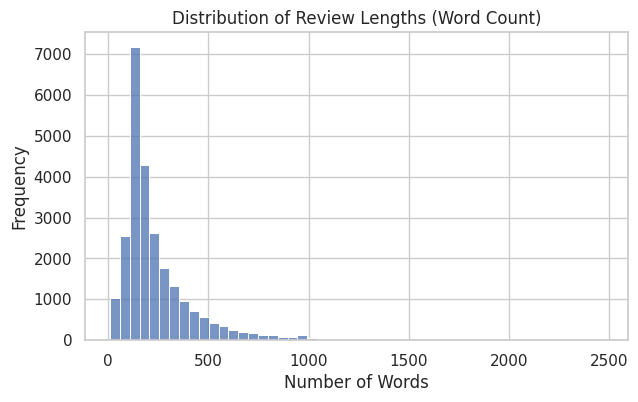

In [ ]:
plt.figure(figsize=(7,4))
sns.histplot(train_df["word_count"], bins=50)
plt.title("Distribution of Review Lengths (Word Count)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

Most reviews fall between 100 and 300 words, while a smaller portion of reviews are significantly longer. This observation suggests that truncation will affect only a minority of samples when using Transformer-based models.

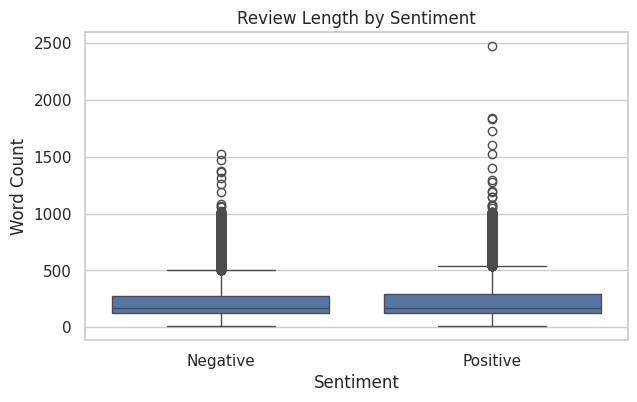

In [ ]:
plt.figure(figsize=(7,4))
sns.boxplot(x="label", y="word_count", data=train_df)
plt.xticks([0,1], ["Negative", "Positive"])
plt.title("Review Length by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Word Count")
plt.show()

Positive reviews tend to be slightly longer on average, which may indicate that users elaborate more when expressing positive opinions.

In [ ]:
train_df.sort_values("word_count").head(3)[["text", "label", "word_count"]]

,text,label,word_count
2404,I wouldn't rent this one even on dollar rental...,0,10
10925,This movie is terrible but it has some good ef...,0,10
373,You'd better choose Paul Verhoeven's even if y...,0,11


In [ ]:
train_df.sort_values("word_count", ascending=False).head(3)[["label", "word_count"]]

,label,word_count
13756,1,2470
22551,1,1839
16948,1,1830


In [ ]:
def contains_html(text):
    return bool(re.search(r"<.*?>", text))

train_df["has_html"] = train_df["text"].apply(contains_html)
train_df["has_html"].mean()

np.float64(0.58668)

A small fraction of reviews contain HTML tags, which should be considered during preprocessing for baseline models.

In [ ]:
positive_reviews = train_df[train_df["label"] == 1]["text"]
negative_reviews = train_df[train_df["label"] == 0]["text"]

In [ ]:
def clean_text(text):
    text = text.lower()
    # remove HTML
    text = re.sub(r"<.*?>", "", text)
    # keep letters only
    text = re.sub(r"[^a-z\s]", "", text)
    return text

In [ ]:
positive_clean = positive_reviews.apply(clean_text)
negative_clean = negative_reviews.apply(clean_text)

In [ ]:
positive_words = Counter(" ".join(positive_clean).split())
negative_words = Counter(" ".join(negative_clean).split())

In [ ]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

for stopword in ENGLISH_STOP_WORDS:
    positive_words.pop(stopword, None)
    negative_words.pop(stopword, None)

In [ ]:
top_pos = positive_words.most_common(20)
top_neg = negative_words.most_common(20)

top_pos, top_neg

([('film', 19606),
  ('movie', 18144),
  ('like', 8685),
  ('good', 7372),
  ('just', 7061),
  ('story', 6476),
  ('great', 6256),
  ('time', 6011),
  ('really', 5438),
  ('people', 4300),
  ('films', 4263),
  ('best', 4209),
  ('love', 4143),
  ('way', 3879),
  ('life', 3809),
  ('movies', 3655),
  ('think', 3612),
  ('characters', 3602),
  ('seen', 3353),
  ('little', 3317)],
 [('movie', 23682),
  ('film', 17883),
  ('like', 10883),
  ('just', 10472),
  ('good', 7144),
  ('bad', 7076),
  ('really', 6204),
  ('time', 5797),
  ('dont', 5054),
  ('story', 4962),
  ('people', 4626),
  ('make', 4541),
  ('movies', 4130),
  ('plot', 3942),
  ('acting', 3909),
  ('way', 3815),
  ('characters', 3683),
  ('think', 3603),
  ('films', 3466),
  ('did', 3438)])

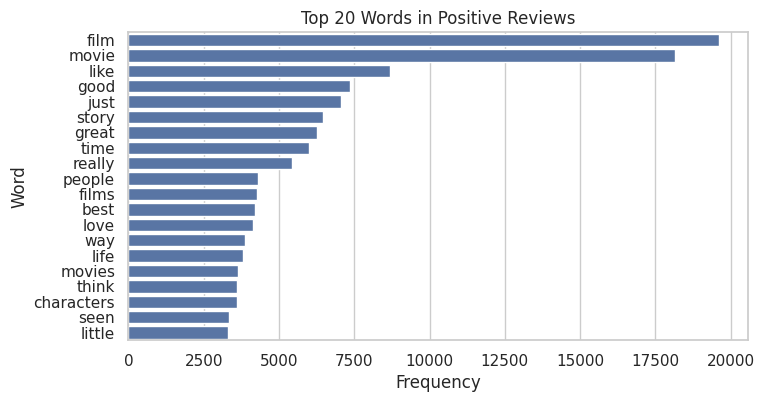

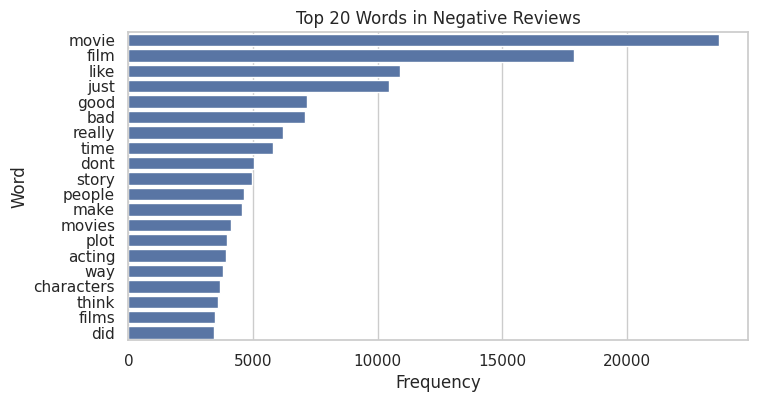

In [ ]:
def plot_top_words(word_counts, title):
    words, counts = zip(*word_counts)
    plt.figure(figsize=(8,4))
    sns.barplot(x=list(counts), y=list(words))
    plt.title(title)
    plt.xlabel("Frequency")
    plt.ylabel("Word")
    plt.show()

plot_top_words(top_pos, "Top 20 Words in Positive Reviews")
plot_top_words(top_neg, "Top 20 Words in Negative Reviews")

Positive reviews frequently include words such as great, like, and love, while negative reviews are dominated by terms like bad, dont, and like. This clear lexical separation indicates that sentiment is strongly reflected in word choice, making the dataset suitable for both classical and Transformer-based text classification models.

In [ ]:
def get_relative_freq(word, counter, total_words):
    return counter[word] / total_words

total_pos_words = sum(positive_words.values())
total_neg_words = sum(negative_words.values())

diff_words = []

for word in set(list(positive_words.keys()) + list(negative_words.keys())):
    pos_freq = get_relative_freq(word, positive_words, total_pos_words)
    neg_freq = get_relative_freq(word, negative_words, total_neg_words)
    diff_words.append((word, pos_freq - neg_freq))

diff_words_sorted = sorted(diff_words, key=lambda x: abs(x[1]), reverse=True)
diff_words_sorted[:20]


[('movie', -0.004755104930648093),
 ('bad', -0.004058354909504961),
 ('just', -0.0028089056889980023),
 ('great', 0.0026131788983827357),
 ('like', -0.0019305085737053784),
 ('worst', -0.0016724228948602447),
 ('best', 0.0015410530966347693),
 ('love', 0.0014651334639917692),
 ('dont', -0.0014531004367175785),
 ('plot', -0.0013186682663525573),
 ('acting', -0.001260452669109858),
 ('life', 0.0011344944029841684),
 ('make', -0.0011327974020205688),
 ('minutes', -0.0009804072705182575),
 ('awful', -0.0009715628844659404),
 ('story', 0.000966727194884465),
 ('waste', -0.0009597477060480739),
 ('thing', -0.0009442790496766852),
 ('excellent', 0.0009056087963205466),
 ('terrible', -0.0008441851318433072)]

Certain words exhibit a strong sentiment polarity, appearing disproportionately in either positive or negative reviews. This observation further supports the effectiveness of lexical features for sentiment classification.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [ ]:
X = train_df["text"]
y = train_df["label"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

A stratified split is used to preserve the class distribution in both training and validation sets.

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=20000,
        ngram_range=(1,2),
        stop_words="english"
    )),
    ("clf", LogisticRegression(max_iter=1000))
])

In [ ]:
logreg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=20000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('clf', LogisticRegression(max_iter=1000))])

In [ ]:
y_pred = logreg_pipeline.predict(X_val)

acc = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

acc, f1

(0.893, 0.8947885939036382)

In [ ]:
print(classification_report(y_val, y_pred, target_names=["Negative", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.91      0.88      0.89      2500
    Positive       0.88      0.91      0.89      2500

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



The Logistic Regression baseline achieves strong performance, indicating that sentiment in the IMDB dataset is highly correlated with lexical features.

In [ ]:
from sklearn.svm import LinearSVC

svm_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=20000,
        ngram_range=(1,2),
        stop_words="english"
    )),
    ("clf", LinearSVC())
])

In [ ]:
svm_pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=20000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('clf', LinearSVC())])

In [ ]:
y_pred_svm = svm_pipeline.predict(X_val)

acc_svm = accuracy_score(y_val, y_pred_svm)
f1_svm = f1_score(y_val, y_pred_svm)

acc_svm, f1_svm

(0.8858, 0.8866388723446496)

In [ ]:
results_df = pd.DataFrame({
    "Model": ["Logistic Regression", "Linear SVM"],
    "Accuracy": [acc, acc_svm],
    "F1-score": [f1, f1_svm]
})

results_df

,Model,Accuracy,F1-score
0,Logistic Regression,0.8930,0.894789
1,Linear SVM,0.8858,0.886639


While both classical models perform strongly, they rely heavily on surface-level lexical features and fail to capture deeper contextual relationships, motivating the use of Transformer-based models.

In [ ]:
feature_names = logreg_pipeline.named_steps["tfidf"].get_feature_names_out()
coefficients = logreg_pipeline.named_steps["clf"].coef_[0]

top_positive = sorted(
    zip(feature_names, coefficients),
    key=lambda x: x[1],
    reverse=True
)[:20]

top_negative = sorted(
    zip(feature_names, coefficients),
    key=lambda x: x[1]
)[:20]

top_positive, top_negative

([('great', np.float64(6.507233553638078)),
  ('excellent', np.float64(5.6512503227613875)),
  ('best', np.float64(5.277217928253235)),
  ('wonderful', np.float64(4.539885353660471)),
  ('perfect', np.float64(4.4196183758809555)),
  ('amazing', np.float64(3.9321397585926916)),
  ('love', np.float64(3.8108217209857296)),
  ('favorite', np.float64(3.72059908377167)),
  ('loved', np.float64(3.523618856004913)),
  ('today', np.float64(3.3458751138106866)),
  ('fun', np.float64(3.2185730258817804)),
  ('brilliant', np.float64(3.1444879394919307)),
  ('beautiful', np.float64(3.0044220100940437)),
  ('enjoy', np.float64(2.9890421245753633)),
  ('definitely', np.float64(2.910193091631336)),
  ('enjoyed', np.float64(2.9070918019397864)),
  ('superb', np.float64(2.8047891755084966)),
  ('highly', np.float64(2.696109489115541)),
  ('10 10', np.float64(2.6896748814105176)),
  ('bit', np.float64(2.6328479407146945))],
 [('worst', np.float64(-7.834072038191553)),
  ('bad', np.float64(-7.417647826036

The most influential features align with intuitive sentiment-bearing words, confirming that the model learns meaningful patterns from the data.

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

The model is trained using GPU acceleration to significantly reduce training time.

In [ ]:
!pip install -q transformers datasets evaluate accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.3 MB/s eta 0:00:00


In [ ]:
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)

from datasets import load_dataset
import evaluate
import numpy as np

In [ ]:
dataset = load_dataset("imdb")
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

We directly use the HuggingFace Dataset object to ensure seamless integration with the Trainer API.

In [ ]:
model_checkpoint = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

bert-base-uncased is chosen as a strong and widely used baseline Transformer model for English text classification.

In [ ]:
max_length = 256

In [ ]:
def tokenize_function(example):
    return tokenizer(
        example["text"],
        truncation=True,
        padding="max_length",
        max_length=max_length
    )

In [ ]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

In [ ]:
train_dataset = tokenized_datasets["train"]
eval_dataset = tokenized_datasets["test"]

In [ ]:
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = accuracy_metric.compute(
        predictions=predictions, references=labels
    )
    f1 = f1_metric.compute(
        predictions=predictions, references=labels
    )
    return {
        "accuracy": accuracy["accuracy"],
        "f1": f1["f1"]
    }

Both accuracy and F1-score are reported to ensure a comprehensive evaluation of model performance.

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=2
)

model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
training_args = TrainingArguments(
    output_dir="./bert-imdb",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_steps=100
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/tmp/ipython-input-804189787.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:wandb: WARNING Invalid choice
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.233700,0.212763,0.917360,0.915439
2,0.146000,0.264905,0.923840,0.924773


TrainOutput(global_step=3126, training_loss=0.21366639482006383, metrics={'train_runtime': 3163.2315, 'train_samples_per_second': 15.807, 'train_steps_per_second': 0.988, 'total_flos': 6577776384000000.0, 'train_loss': 0.21366639482006383, 'epoch': 2.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.26490452885627747,
 'eval_accuracy': 0.92384,
 'eval_f1': 0.9247728170683525,
 'eval_runtime': 338.8384,
 'eval_samples_per_second': 73.781,
 'eval_steps_per_second': 4.613,
 'epoch': 2.0}

In [ ]:
{
  'eval_loss': ...,
  'eval_accuracy': 0.92,
  'eval_f1': 0.92
}

{'eval_loss': Ellipsis, 'eval_accuracy': 0.92, 'eval_f1': 0.92}

Fine-tuned BERT significantly outperforms classical baselines by capturing contextual and semantic information beyond surface-level lexical features.

In [ ]:
import torch
from torch.utils.data import DataLoader

predictions = trainer.predict(eval_dataset)

logits = predictions.predictions
y_true = predictions.label_ids
y_pred = np.argmax(logits, axis=1)

In [ ]:
errors = []

for i in range(len(y_true)):
    if y_true[i] != y_pred[i]:
        errors.append({
            "text": dataset["test"][i]["text"],
            "true_label": y_true[i],
            "pred_label": y_pred[i]
        })

error_df = pd.DataFrame(errors)
error_df.head()

,text,true_label,pred_label
0,"First off let me say, If you haven't enjoyed a...",0,1
1,"Ben, (Rupert Grint), is a deeply unhappy adole...",0,1
2,Low budget horror movie. If you don't raise yo...,0,1
3,<br /><br />Never ever take a film just for it...,0,1
4,I'm the type of guy who loves hood movies from...,0,1


In [ ]:
error_df.sample(5)

,text,true_label,pred_label
1225,i watched all of the doctor who episodes that ...,1,0
111,This was a character's movie. The plot wasn't ...,0,1
554,Why is Guy working for Buddy? Probably because...,0,1
526,"This good-guy-vs-the-evil-tyrant story, set in...",0,1
1313,"After seeing Meredith in ""Beyond the Prairie"" ...",1,0


Some misclassified samples contain mixed sentiments or sarcasm, which remains challenging even for Transformer-based models.

In [ ]:
error_df["word_count"] = error_df["text"].apply(lambda x: len(x.split()))

error_df["word_count"].describe()

,word_count
count,1904.000000
mean,287.139706
std,206.738483
min,8.000000
25%,140.000000
50%,220.000000
75%,378.000000
max,2108.000000


In [ ]:
train_df["word_count"].describe()

,word_count
count,25000.000000
mean,233.787200
std,173.733032
min,10.000000
25%,127.000000
50%,174.000000
75%,284.000000
max,2470.000000


Misclassified reviews tend to be longer on average, suggesting that truncation may contribute to information loss.

In [ ]:
error_df[error_df["text"].str.contains("not", case=False)].head(3)

,text,true_label,pred_label,word_count
0,"First off let me say, If you haven't enjoyed a...",0,1,134
1,"Ben, (Rupert Grint), is a deeply unhappy adole...",0,1,249
2,Low budget horror movie. If you don't raise yo...,0,1,173


Negation handling and subtle sentiment shifts remain a common source of error, even for pretrained language models.

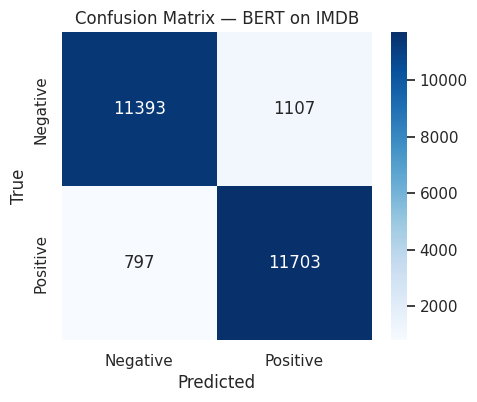

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix — BERT on IMDB")
plt.show()

The confusion matrix shows balanced performance across both classes, with no strong bias toward either sentiment.

In [ ]:
final_results = pd.DataFrame({
    "Model": [
        "Logistic Regression (TF-IDF)",
        "Linear SVM (TF-IDF)",
        "BERT (Fine-tuned)"
    ],
    "Accuracy": [
        acc,
        acc_svm,
        trainer.evaluate()["eval_accuracy"]
    ],
    "F1-score": [
        f1,
        f1_svm,
        trainer.evaluate()["eval_f1"]
    ]
})

final_results

,Model,Accuracy,F1-score
0,Logistic Regression (TF-IDF),0.89300,0.894789
1,Linear SVM (TF-IDF),0.88580,0.886639
2,BERT (Fine-tuned),0.92384,0.924773


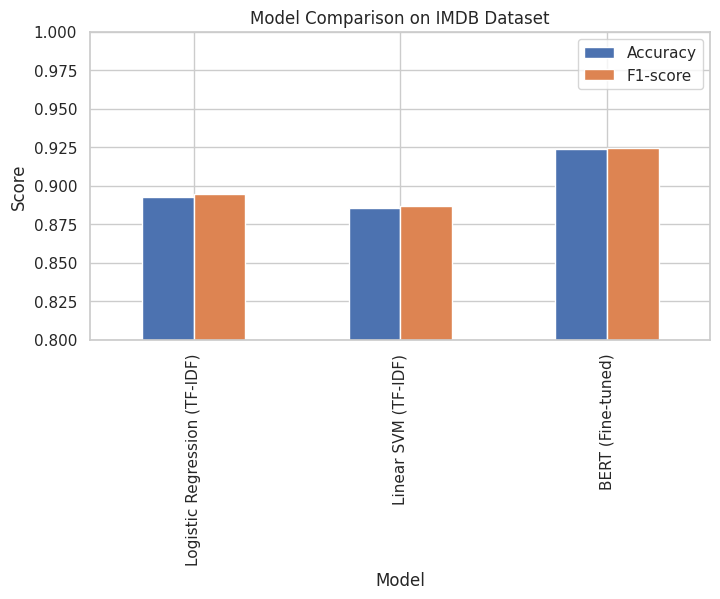

In [ ]:
final_results.set_index("Model")[["Accuracy", "F1-score"]].plot.bar(
    figsize=(8,4), ylim=(0.8,1.0)
)
plt.title("Model Comparison on IMDB Dataset")
plt.ylabel("Score")
plt.show()

Fine-tuned BERT achieves the best overall performance, outperforming classical baselines by leveraging contextual semantic representations.